# Why Feature Selection?

In [852]:
# Import
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import sklearn.linear_model as skl_lm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import chi2


In [791]:
# Import the dataset
df = pd.read_csv('data/Default.csv')

In [792]:
df

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625074
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138947
3,4,No,No,529.250605,35704.493935
4,5,No,No,785.655883,38463.495879
...,...,...,...,...,...
9995,9996,No,No,711.555020,52992.378914
9996,9997,No,No,757.962918,19660.721768
9997,9998,No,No,845.411989,58636.156984
9998,9999,No,No,1569.009053,36669.112365


In [793]:
df.set_index('Unnamed: 0', inplace=True)
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df

,default,student,balance,income,default2,student2
Unnamed: 0,,,,,,
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0
4,No,No,529.250605,35704.493935,0,0
5,No,No,785.655883,38463.495879,0,0
...,...,...,...,...,...,...
9996,No,No,711.555020,52992.378914,0,0
9997,No,No,757.962918,19660.721768,0,0
9998,No,No,845.411989,58636.156984,0,0


# Balancing The Dataset

In [794]:
y = df.default2
print(y.value_counts())

default2
0    9667
1     333
Name: count, dtype: int64


We observe that class 0, corresponding to non-defaults, contains 9,667 observations, while class 1, representing defaults, has only 333 observations. This significant disparity in class distribution makes the dataset highly imbalanced, a characteristic that could hinder the model's ability to generalize, particularly in accurately predicting the minority class.

In [795]:
# Get the indexes of the rows for each class
index_class_0 = y[y == 0].index
index_class_1 = y[y == 1].index

index_class_1

Index([ 137,  174,  202,  207,  210,  242,  244,  264,  342,  346,
       ...
       9797, 9814, 9857, 9884, 9894, 9913, 9922, 9950, 9952, 9979],
      dtype='int64', name='Unnamed: 0', length=333)

We randomly select a number of observations from the majority class equal to the number of observations in the minority class. This approach, known as <b>random undersampling</b>, aims to balance the dataset by reducing the size of the majority class, ensuring an equal representation of both classes.

In [796]:
# Select the same number of rows for each class
same_size_index_class_0 = np.random.choice(index_class_0, y.value_counts().min(), replace=False)

all_index = np.concatenate([index_class_1, same_size_index_class_0])
df = df.loc[all_index]
print(f'Numero di osservazioni totali: {df.shape}')

Numero di osservazioni totali: (666, 6)


# Train & Test Split

In [797]:
x = df.balance.values.reshape(-1,1) # scikit-learn expects a 2D array not a pd.Series :(
y = df.default2


We now proceed to split the dataset into training and testing sets, applying stratification based on the target variable, y.

Stratification ensures that the proportion of classes in the target variable remains consistent across both the training and testing sets. For example, if class 0 (non-default) constitutes 90% of the dataset and class 1 (default) 10%, the same ratio will be preserved in both subsets. This technique is crucial for maintaining the representativeness of the data distribution and for ensuring that the model is evaluated on a test set with a class distribution similar to the original dataset.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)


In [799]:
print(f'y train:\n\n{y_train.value_counts()}\n\n{'-'*50}\n')
print(f'y test:\n\n{y_test.value_counts()}')

y train:

default2
1    266
0    266
Name: count, dtype: int64

--------------------------------------------------

y test:

default2
0    67
1    67
Name: count, dtype: int64


# Logistic Regression: Single Predictor

In [800]:
X_train_w_intercept = sm.add_constant(pd.DataFrame(X_train))
est = sm.Logit(y_train.to_numpy(), X_train_w_intercept).fit()
est.summary2().tables[1]


Optimization terminated successfully.
         Current function value: 0.325460
         Iterations 7


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-6.544817,0.572684,-11.428332,3.018523e-30,-7.667256,-5.422378
0,0.004885,0.000406,12.028847,2.506351e-33,0.004089,0.005681


The logistic regression results suggest the following:

Intercept (const):

The coefficient for the intercept is -6.54, indicating the baseline log-odds of default when the balance variable is 0.
The p-value associated with the intercept is extremely low (3.02e-30), indicating that the intercept is statistically significant.
Coefficient for balance:

The coefficient for balance is 0.00489, meaning that for each one-unit increase in the balance, the log-odds of default increase by 0.00489.
This coefficient translates to an odds ratio of approximately 
𝑒
0.00489
≈
1.0049
e 
0.00489
 ≈1.0049, suggesting that a higher account balance slightly increases the likelihood of default.
The p-value for balance is extremely low (2.51e-33), confirming that balance is a highly significant predictor of default.
Standard Errors and Confidence Intervals:

The standard errors are relatively small for both coefficients, indicating precise estimates.
The 95% confidence interval for the balance coefficient ([0.00409, 0.00568]) does not include 0, reinforcing its significance.
Interpretation:
The variable balance has a statistically significant positive association with the probability of default, but the effect size is small. This means that while balance is an important predictor, its practical impact might require consideration of additional variables for a more comprehensive model.
The model's ability to predict default accurately will depend on further evaluation using metrics like AUC-ROC, precision, recall, or confusion matrix analysis.

In [801]:
X_test_w_intercept = sm.add_constant(pd.DataFrame(X_test))
y_prob = est.predict(X_test_w_intercept)
y_pred = (y_prob > 0.5).astype(int)

In [802]:
print(y_prob)

0      0.333272
1      0.752811
2      0.525225
3      0.867616
4      0.717538
         ...   
129    0.305622
130    0.965978
131    0.156050
132    0.544576
133    0.936136
Length: 134, dtype: float64


# Model Evaluation

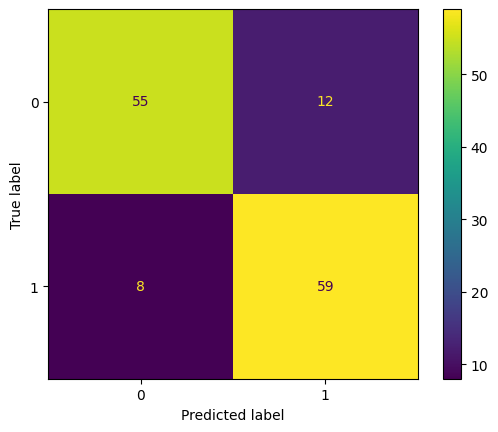

In [803]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

Accurcacy 1 regressor: 0.8507462686567164


In [ ]:
# Calculate accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)

# Calculate AUC-ROC
auc = roc_auc_score(y_test, y_pred)

# Calculate Gini Index
gini_index = 2 * auc - 1

print('Accurcacy 1 regressor:',accuracy)
print(f"AUC-ROC: {auc}")
print(f"Gini Index: {gini_index}")

AUC-ROC: 0.8582089552238806
Gini Index: 0.7164179104477613


# Fake Data Augmentation

In [805]:
# Create 5 new syntetic columns with random values
for i in range(5):
    df[f'random_{i}'] = np.random.rand(df.shape[0])

# Create 5 new columns correlated with balance with some noise
for i in range(5):
    df[f'correlated_{i}'] = df.balance + np.random.normal(1, 10, df.shape[0])



The code introduces synthetic data to test the model's robustness and observe its performance when the dataset includes additional irrelevant and noisy features. This is a common practice for evaluating the behavior of machine learning models under less ideal conditions.

1. Adding Random Features:
    - What It Does: Creates 5 new columns (random_0 to random_4) filled with random values uniformly distributed between 0 and 1. These columns have no relationship with the target variable (default) or the key feature (balance).
    - Purpose: To introduce purely irrelevant noise into the dataset and analyze how the model handles these features during training. A well-regularized model should assign minimal weights to these features.

2. Adding Correlated Features with Noise:
    - What It Does: Creates 5 new columns (correlated_0 to correlated_4) that are loosely correlated with the balance feature. These features are generated by adding random noise, sampled from a normal distribution (
𝜇
=
1
,
𝜎
=
10
μ=1,σ=10), to the balance variable.
    - Purpose: To introduce features that have a weak but non-zero relationship with balance and observe whether the model can leverage this relationship effectively without being overly influenced by the noise.

Commentary:
Impact on Model Performance: Adding irrelevant and noisy features is expected to reduce the model's performance. For logistic regression, the added noise can lead to:
Overfitting, where the model assigns weights to irrelevant features.
Reduced interpretability, as the coefficients may become less meaningful due to the presence of spurious relationships.
Evaluating Robustness: By training the model with this augmented dataset, we can evaluate:
Whether the model correctly identifies balance as the most predictive feature.
Whether regularization techniques (e.g., L1 or L2 penalties) are effective in mitigating the impact of noisy or irrelevant features.
Expected Outcome: The model’s predictive power (e.g., AUC-ROC, accuracy) is likely to decline compared to the original dataset, demonstrating its sensitivity to noise.

In [ ]:
df

New columns:
Index(['default', 'student', 'balance', 'income', 'default2', 'student2',
       'random_0', 'random_1', 'random_2', 'random_3', 'random_4',
       'correlated_0', 'correlated_1', 'correlated_2', 'correlated_3',
       'correlated_4'],
      dtype='object')


,default,student,balance,income,default2,student2,random_0,random_1,random_2,random_3,random_4,correlated_0,correlated_1,correlated_2,correlated_3,correlated_4
Unnamed: 0,,,,,,,,,,,,,,,,
137,Yes,Yes,1486.998122,17854.397028,1,1,0.087456,0.010475,0.099740,0.116285,0.032453,1478.265328,1487.381940,1482.296958,1494.047008,1487.768337
174,Yes,Yes,2205.799521,14271.492253,1,1,0.604803,0.104838,0.937829,0.670001,0.059854,2206.125661,2205.078460,2217.104608,2187.871775,2212.042888
202,Yes,Yes,1774.694223,20359.506086,1,1,0.203871,0.022292,0.120668,0.812125,0.965551,1782.913152,1750.616907,1767.357525,1778.319585,1784.576894
207,Yes,No,1889.599190,48956.171589,1,0,0.855516,0.534469,0.015857,0.887740,0.284327,1901.322329,1890.604605,1884.611750,1884.633500,1892.761234
210,Yes,Yes,1899.390626,20655.200003,1,1,0.184434,0.679533,0.127161,0.991985,0.565177,1896.363573,1886.262445,1922.377014,1882.676720,1892.396559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5268,No,No,707.573103,48790.402248,0,0,0.495811,0.076381,0.202283,0.005804,0.215166,725.087168,705.211575,712.120186,719.860924,715.162760
9652,No,Yes,1170.911536,19473.691926,0,1,0.833630,0.220121,0.728954,0.221759,0.559180,1201.354013,1169.331250,1161.712218,1176.842455,1171.224635
3242,No,No,1289.602237,35164.889759,0,0,0.908533,0.606605,0.998260,0.352172,0.086432,1275.545748,1294.108276,1290.364580,1283.567100,1292.096437


In [807]:
unselected_columns = ['default', 'student', 'default2', 'student2']
selected_columns = [col for col in df.columns if col not in unselected_columns]
print(f'Selected columns:\n{selected_columns}')

Selected columns:
['balance', 'income', 'random_0', 'random_1', 'random_2', 'random_3', 'random_4', 'correlated_0', 'correlated_1', 'correlated_2', 'correlated_3', 'correlated_4']


In [808]:
print(f'Shape del dataframe:\n{df[selected_columns].shape}')

Shape del dataframe:
(666, 12)


In [809]:
# Select all the columns that are not 'default' or 'student'
X = df[selected_columns]
y = df.default2

print(X.shape)

(666, 12)


# Train & Test split with fake data

In [810]:
# Divide the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [811]:
print(y_train.value_counts())


default2
0    266
1    266
Name: count, dtype: int64


# Logistic Regression: Multiple Predictors

In [812]:
# Fit the model
X_train_w_intercept = sm.add_constant(X_train)
est = sm.Logit(y_train, X_train_w_intercept).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.310984
         Iterations 8


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-7.025566,0.945913,-7.427282,1.108519e-13,-8.879522,-5.171610
balance,0.013001,0.029959,0.433949,6.643255e-01,-0.045718,0.071720
income,0.000018,0.000011,1.726049,8.433852e-02,-0.000002,0.000039
random_0,-0.251528,0.483842,-0.519855,6.031643e-01,-1.199840,0.696784
random_1,-0.291405,0.506313,-0.575544,5.649237e-01,-1.283759,0.700949
random_2,-0.516391,0.512917,-1.006773,3.140440e-01,-1.521690,0.488908
random_3,0.168331,0.477026,0.352877,7.241808e-01,-0.766622,1.103284
random_4,0.179367,0.501945,0.357343,7.208351e-01,-0.804428,1.163161
correlated_0,-0.001649,0.013683,-0.120483,9.041005e-01,-0.028467,0.025170
correlated_1,-0.012821,0.013842,-0.926251,3.543155e-01,-0.039951,0.014308


In [813]:
X_test_w_intercept = sm.add_constant(X_test)
y_prob = est.predict(X_test_w_intercept)
y_pred = (y_prob > 0.5).astype(int)


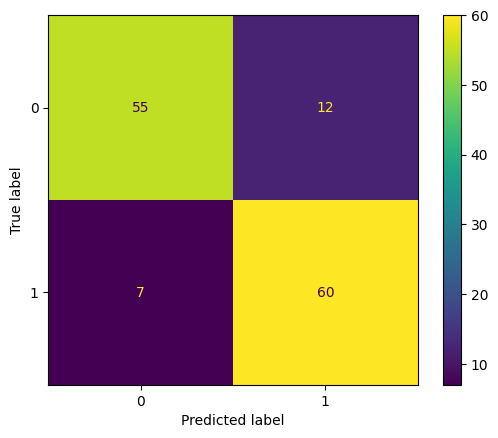

In [814]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [815]:
# Accuracy
new_accuracy = metrics.accuracy_score(y_test, y_pred)
new_accuracy
print('Accurcacy multiple regressors (no selection):', new_accuracy)


Accurcacy multiple regressors (no selection): 0.8582089552238806


In [816]:
if new_accuracy > accuracy:
    print('The accuracy has improved')
elif new_accuracy == accuracy:
    print('The accuracy is the same')
else:
    print('The accuracy is worse')

The accuracy has improved


# Outlier analysis

In [817]:
phone_df = pd.read_csv('data/phone.csv')
phone_df.head()

,phone_name,brand,os,inches,resolution,battery,battery_type,ram(GB),announcement_date,weight(g),...,video_1080p,video_4K,video_8K,video_30fps,video_60fps,video_120fps,video_240fps,video_480fps,video_960fps,price(USD)
0,Y6II Compact,Huawei,Android 5.1,5.0,720x1280,2200,Li-Po,2,2016-09-01,140.0,...,False,False,False,True,False,False,False,False,False,120.0
1,K20 plus,LG,Android 7.0,5.3,720x1280,2700,Li-Ion,2,2016-12-01,140.0,...,True,False,False,True,False,False,False,False,False,100.0
2,P8 Lite (2017),Huawei,Android 7.0,5.2,1080x1920,3000,Li-Ion,4,2017-01-01,147.0,...,True,False,False,True,False,False,False,False,False,420.0
3,Redmi Note 4,Xiaomi,Android 6.0,5.5,1080x1920,4100,Li-Po,4,2017-01-01,165.0,...,True,False,False,True,False,True,False,False,False,150.0
4,P10,Huawei,Android 7.0,5.1,1080x1920,3200,Li-Ion,4,2017-02-01,145.0,...,True,True,False,True,True,False,False,False,False,420.0


In [818]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   phone_name         1512 non-null   object 
 1   brand              1512 non-null   object 
 2   os                 1512 non-null   object 
 3   inches             1512 non-null   float64
 4   resolution         1512 non-null   object 
 5   battery            1512 non-null   int64  
 6   battery_type       1512 non-null   object 
 7   ram(GB)            1512 non-null   int64  
 8   announcement_date  1512 non-null   object 
 9   weight(g)          1512 non-null   float64
 10  storage(GB)        1512 non-null   int64  
 11  video_720p         1512 non-null   bool   
 12  video_1080p        1512 non-null   bool   
 13  video_4K           1512 non-null   bool   
 14  video_8K           1512 non-null   bool   
 15  video_30fps        1512 non-null   bool   
 16  video_60fps        1512 

In [819]:
y = phone_df['price(USD)']
X = phone_df.drop(columns='price(USD)')

In [842]:
# Numerical columns
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
print(numeric_columns.to_list())


['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']


array([[<Axes: title={'center': 'feature_0'}>]], dtype=object)

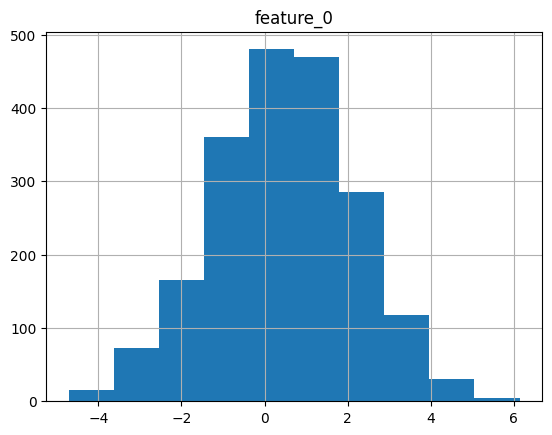

In [849]:
X[['feature_0']].hist()

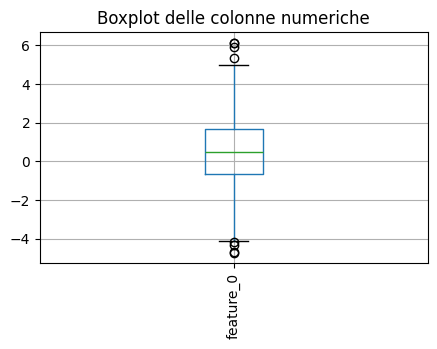

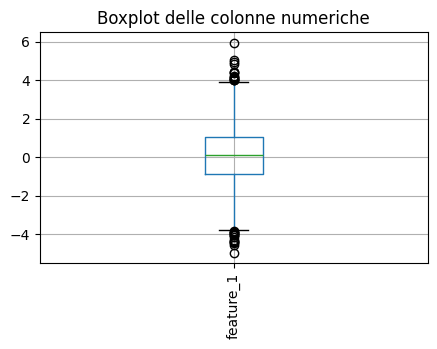

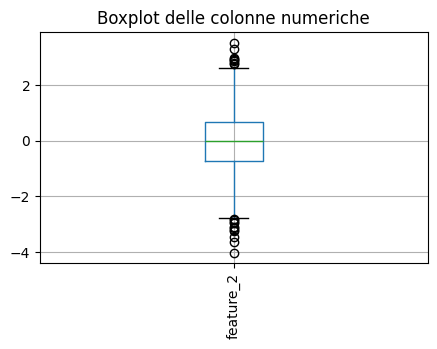

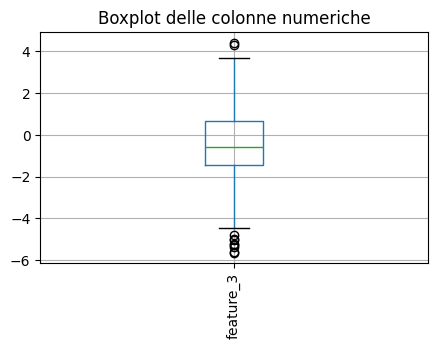

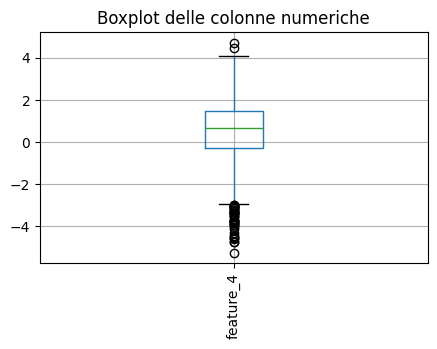

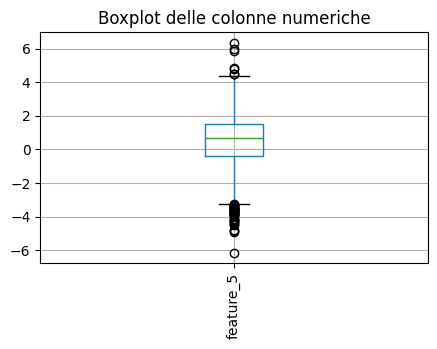

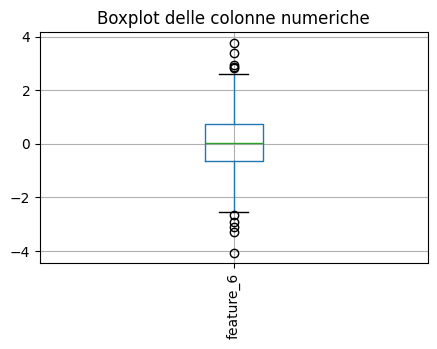

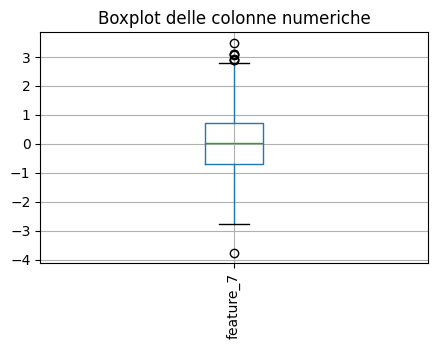

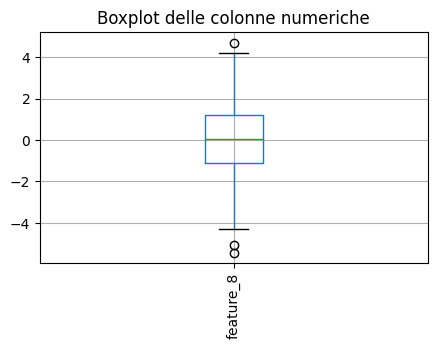

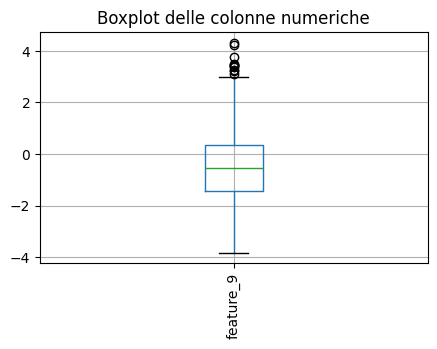

In [848]:
# Boxplot
for i in numeric_columns:
    plt.figure(figsize=(5, 3))
    X[[i]].boxplot()
    plt.xticks(rotation=90)
    plt.title('Boxplot delle colonne numeriche')
    plt.show()
    

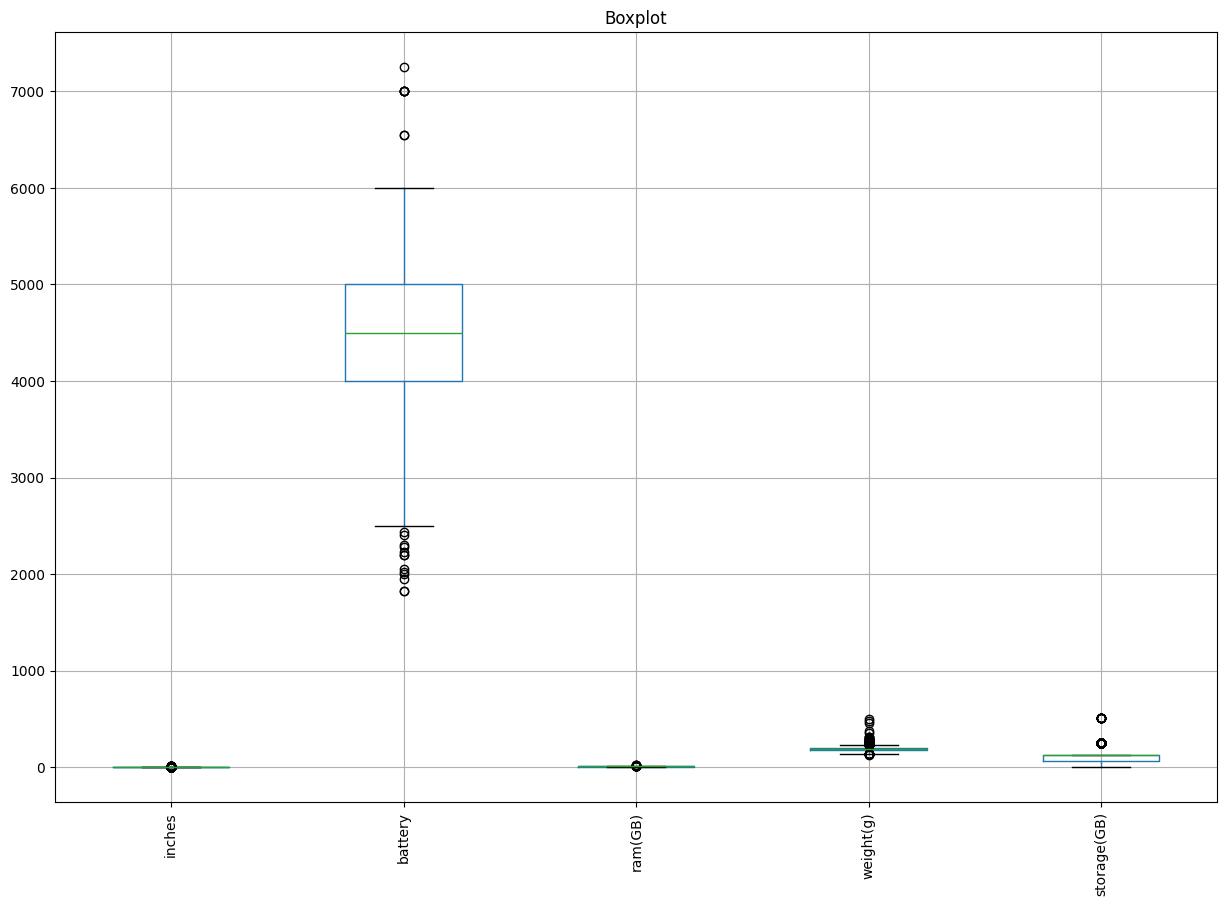

In [822]:
from packages.data_analysis import standard_box_plot

standard_box_plot(X[numeric_columns])

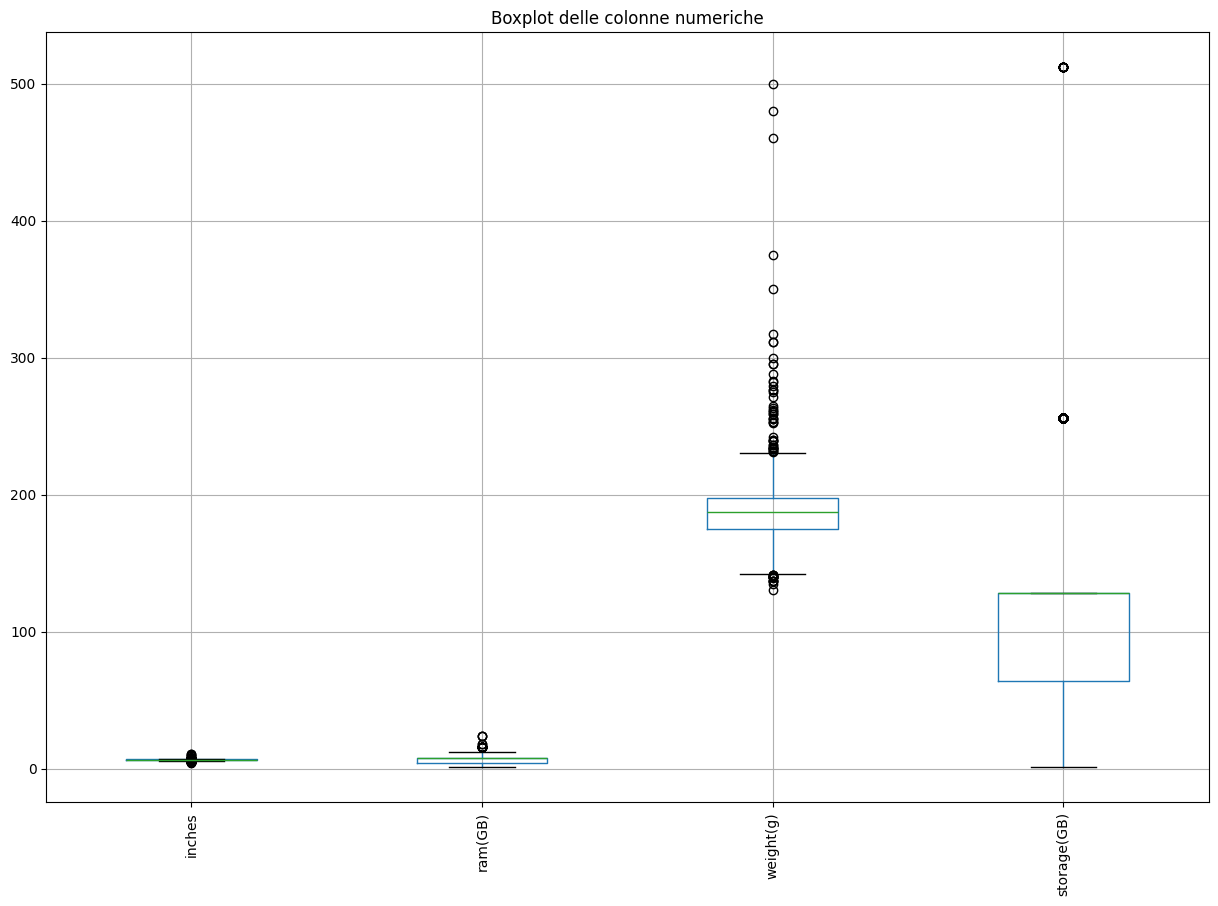

In [823]:
# Boxplot
plt.figure(figsize=(15, 10))
X[numeric_columns].drop(columns='battery').boxplot()
plt.xticks(rotation=90)
plt.title('Boxplot delle colonne numeriche')
plt.show()

In [824]:
X.describe()

,inches,battery,ram(GB),weight(g),storage(GB)
count,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000
mean,6.422460,4389.798942,6.683862,187.636243,109.164683
std,0.477043,784.607022,2.701433,26.200115,74.436484
min,3.800000,1821.000000,1.000000,130.000000,1.000000
25%,6.300000,4000.000000,4.000000,175.000000,64.000000
50%,6.500000,4500.000000,8.000000,187.000000,128.000000
75%,6.670000,5000.000000,8.000000,197.250000,128.000000
max,10.400000,7250.000000,24.000000,500.000000,512.000000


In [825]:
# Interquartile range
def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

outliers = {column: find_outliers(X, column) for column in numeric_columns}
outliers

{'inches':               phone_name    brand           os  inches resolution  battery  \
 0           Y6II Compact   Huawei  Android 5.1    5.00   720x1280     2200   
 1               K20 plus       LG  Android 7.0    5.30   720x1280     2700   
 2         P8 Lite (2017)   Huawei  Android 7.0    5.20  1080x1920     3000   
 3           Redmi Note 4   Xiaomi  Android 6.0    5.50  1080x1920     4100   
 4                    P10   Huawei  Android 7.0    5.10  1080x1920     3200   
 ...                  ...      ...          ...     ...        ...      ...   
 1436          Pixel Fold   Google   Android 13    7.60  1840x2208     4821   
 1489            Magic V2    Honor   Android 13    7.92  2156x2344     5000   
 1492  Legion Y700 (2023)   Lenovo   Android 13    8.80  1600x2560     6550   
 1497      Galaxy Z Fold5  Samsung   Android 13    7.60  1812x2176     4400   
 1504          Mix Fold 3   Xiaomi   Android 13    8.03  1916x2160     4800   
 
      battery_type  ram(GB) announcement

In [826]:
outliers['battery'].head(5)

,phone_name,brand,os,inches,resolution,battery,battery_type,ram(GB),announcement_date,weight(g),...,video_720p,video_1080p,video_4K,video_8K,video_30fps,video_60fps,video_120fps,video_240fps,video_480fps,video_960fps
0,Y6II Compact,Huawei,Android 5.1,5.0,720x1280,2200,Li-Po,2,2016-09-01,140.0,...,True,False,False,False,True,False,False,False,False,False
5,Xperia XA1,Sony,Android 7.0,5.0,720x1280,2300,Li-Ion,3,2017-02-01,143.0,...,False,True,False,False,True,False,False,False,False,False
27,Y3 (2017),Huawei,Android 6.0,5.0,480x854,2200,Li-Ion,1,2017-05-01,175.0,...,True,False,False,False,True,False,False,False,False,False
28,Z4,Samsung,Tizen 3.0,4.5,480x800,2050,Li-Ion,1,2017-05-01,143.0,...,True,False,False,False,True,False,False,False,False,False
45,Galaxy Folder2,Samsung,Android 6.0,3.8,480x800,1950,Li-Ion,3,2017-07-01,165.0,...,False,True,False,False,True,False,False,False,False,False


In [827]:
# Outliers count
outliers_count = {column: len(outliers[column]) for column in numeric_columns}

outliers_stats = {}
for column in numeric_columns:
    outliers_stats[column] = {
        'Number of Outliers': len(outliers[column]),
        'Percentage of Outliers': (len(outliers[column]) / len(df)) * 100,
        'Outlier Values': outliers[column][column].values
    }

outliers_stats_df = pd.DataFrame(outliers_stats).transpose()
outliers_stats_df

,Number of Outliers,Percentage of Outliers,Outlier Values
inches,164,24.624625,"[5.0, 5.3, 5.2, 5.5, 5.1, 5.0, 5.2, 5.5, 5.5, ..."
battery,21,3.153153,"[2200, 2300, 2200, 2050, 1950, 1821, 2000, 700..."
ram(GB),35,5.255255,"[16, 16, 16, 16, 16, 18, 16, 18, 16, 16, 16, 1..."
weight(g),65,9.75976,"[140.0, 140.0, 141.0, 140.0, 137.0, 130.0, 500..."
storage(GB),167,25.075075,"[256, 256, 512, 256, 256, 512, 512, 256, 512, ..."


# Feature Selection
Feature selection is primarily focused on removing non-informative or redundant predictors from the model.



### Regression Feature Selection: (Numerical Input, Numerical Output)
Pearson's Correlation Coefficient via the f_regression()

In [828]:
# pearson's correlation feature selection for numeric input and numeric output
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_regression

# Informative features numeber
n_informative = 5

# generate dataset
X, y = make_regression(n_samples=2000, n_features=10, n_informative=n_informative, random_state=42)

# Informative features
informative_indices = list(range(n_informative))

# define feature selection
fs = SelectKBest(score_func=f_regression, k=n_informative)

# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(2000, 5)


In [829]:
selected_indices = fs.get_support(indices=True)
selected_features = [str(i) for i in selected_indices]

print("Caratteristiche selezionate:", selected_features)

# Verify intersection between selected and informative features
selected_informative = set(informative_indices).intersection(set(selected_indices))

print("Caratteristiche informative originali selezionate:", selected_informative)

Caratteristiche selezionate: ['0', '1', '3', '4', '6']
Caratteristiche informative originali selezionate: {np.int64(0), np.int64(1), np.int64(3), np.int64(4)}


### Classification Feature Selection: (Numerical Input, Categorical Output)
ANOVA F measure via the f_classif() function

In [830]:
# ANOVA feature selection for numeric input and categorical output
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest

# Informative features numeber
n_informative = 5

# generate dataset
X, y = make_classification(n_samples=2000, n_features=10, n_informative=n_informative, random_state=42)

# Informative features
informative_indices = list(range(n_informative))

# define feature selection
fs = SelectKBest(score_func=f_classif, k=n_informative)

# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(2000, 5)


In [831]:
selected_indices = fs.get_support(indices=True)
selected_features = [str(i) for i in selected_indices]

print("Caratteristiche selezionate:", selected_features)

# Verify intersection between selected and informative features
selected_informative = set(informative_indices).intersection(set(selected_indices))

print("Caratteristiche informative originali selezionate:", selected_informative)

Caratteristiche selezionate: ['0', '1', '3', '4', '5']
Caratteristiche informative originali selezionate: {np.int64(0), np.int64(1), np.int64(3), np.int64(4)}


### Classification Feature Selection: (Categorical Input, Categorical Output)

In [832]:
# Informative features numeber
n_informative = 5

# ANOVA feature selection for numeric input and categorical output
X, y = make_classification(n_samples=2000, n_features=10, n_informative=n_informative, random_state=42)

# Create cols names
X_columns = [f'feature_{i}' for i in range(X.shape[1])] 
X = pd.DataFrame(X, columns=X_columns)
X.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
0,1.719421,-0.995037,1.347159,-0.105095,2.238050,0.120165,0.630093,0.341180,0.365803,-1.431276
1,1.628344,-0.526241,0.116202,1.399840,1.955209,0.610469,-0.102266,1.759813,0.484695,-1.058643
2,0.855182,1.525454,1.932957,-2.284388,-1.581202,1.583316,0.696688,-0.174947,-0.090593,0.141984
3,-0.941105,0.497089,0.092564,-1.726259,0.285517,1.766985,0.434362,-1.748067,-1.935114,0.172213
4,2.071204,-2.098212,-0.411422,1.224860,1.119426,-2.787236,0.373257,-0.193602,1.895603,-0.823585


In [833]:
# Create bins for each column
X_binned = pd.DataFrame(columns=X_columns)
for column in X_columns:
    X_binned[str(column)] = pd.cut(X[column], bins=5, labels=False)

# Convert every column to categorical
for column in X_binned.columns:
    X_binned[column] = X_binned[column].astype('category')

X_binned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   feature_0  2000 non-null   category
 1   feature_1  2000 non-null   category
 2   feature_2  2000 non-null   category
 3   feature_3  2000 non-null   category
 4   feature_4  2000 non-null   category
 5   feature_5  2000 non-null   category
 6   feature_6  2000 non-null   category
 7   feature_7  2000 non-null   category
 8   feature_8  2000 non-null   category
 9   feature_9  2000 non-null   category
dtypes: category(10)
memory usage: 21.7 KB


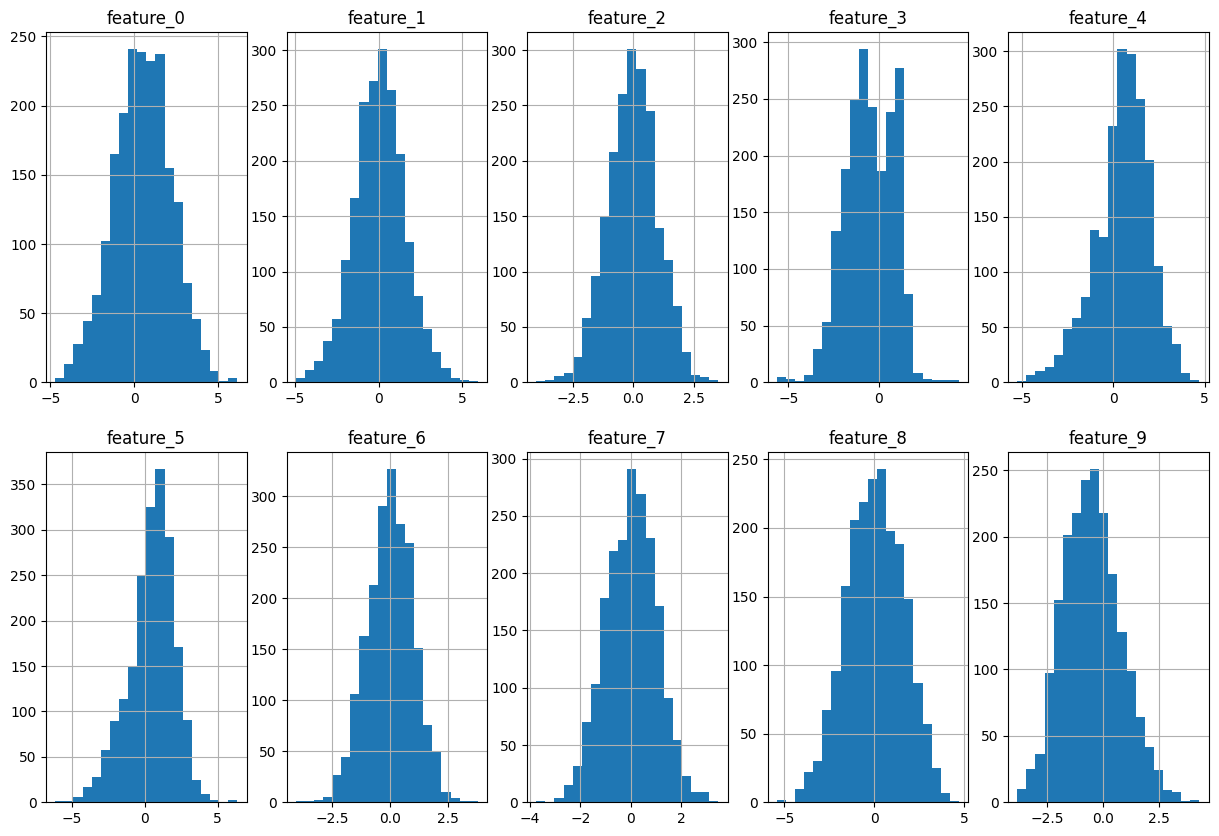

In [834]:
# Create histograms for x 
plt.figure(figsize=(15, 10))
for i, column in enumerate(X_columns):
    plt.subplot(2, 5, i + 1)
    X[column].hist(bins=20)
    plt.title(column)
plt.show()


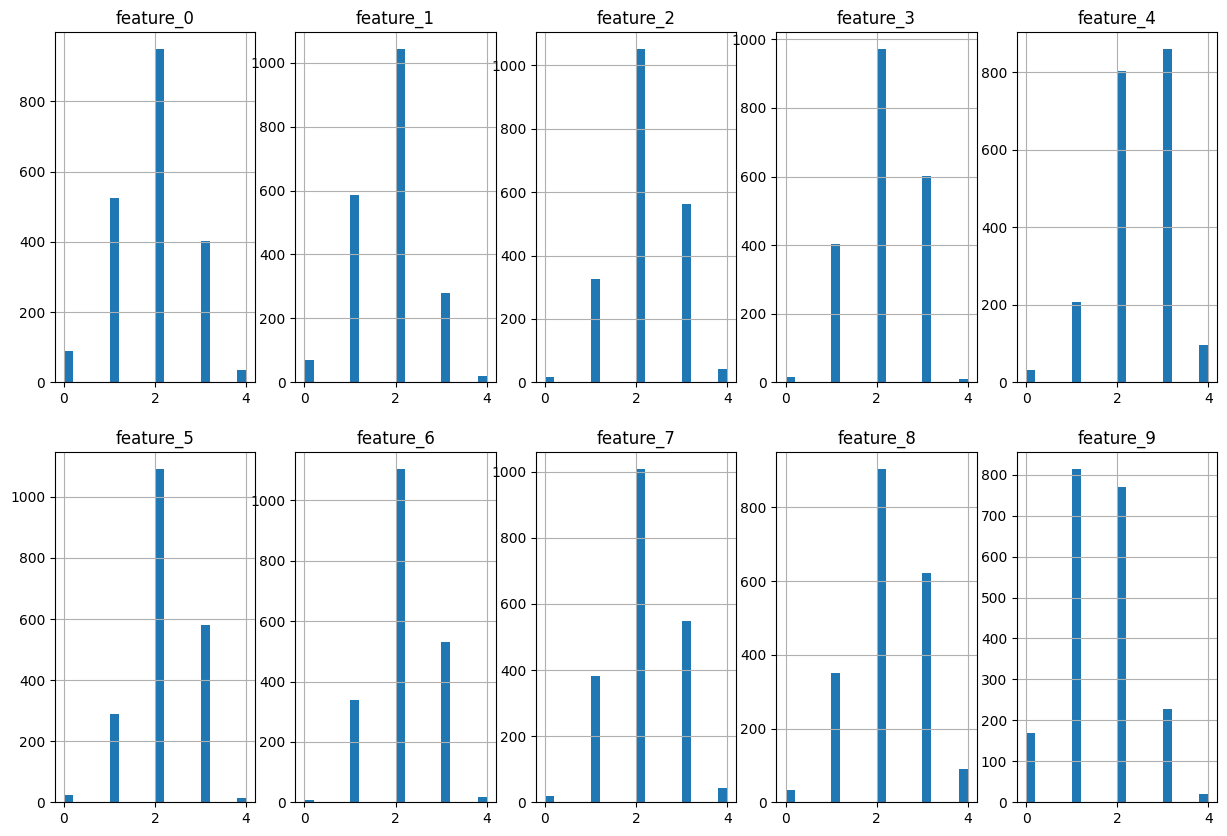

In [835]:
# Create histograms for x binned
plt.figure(figsize=(15, 10))
for i, column in enumerate(X_columns):
    plt.subplot(2, 5, i + 1)
    X_binned[column].hist(bins=20)
    plt.title(column)
plt.show()

In [836]:
X_binned['feature_0'].unique()

[2, 1, 3, 0, 4]
Categories (5, int64): [0, 1, 2, 3, 4]

In [837]:
X_binned.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
0,2,1,3,2,3,2,2,2,2,1
1,2,2,2,3,3,2,2,3,2,1
2,2,2,3,1,1,3,3,2,2,2
3,1,2,2,1,2,3,2,1,1,2
4,3,1,2,3,3,1,2,2,3,1


In [838]:
from packages.data_analysis import standard_OHE

X_encoded = standard_OHE(X_binned)
X_encoded.head()

,feature_0_0,feature_0_1,feature_0_2,feature_0_3,feature_0_4,feature_1_0,feature_1_1,feature_1_2,feature_1_3,feature_1_4,...,feature_8_0,feature_8_1,feature_8_2,feature_8_3,feature_8_4,feature_9_0,feature_9_1,feature_9_2,feature_9_3,feature_9_4
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [839]:
# Informative features
informative_indices = list(range(n_informative))

# Convert to numpy array
X_encoded = X_encoded.values

# Define feature selection
fs = SelectKBest(score_func=chi2, k=n_informative)

# Apply feature selection
X_selected = fs.fit_transform(X_encoded, y)
print(X_selected.shape)

(2000, 5)


In [840]:
selected_indices = fs.get_support(indices=True)
selected_features = [str(i) for i in selected_indices]

print("Selected Features:", selected_features)

for i in selected_indices:
    if i < n_informative*5:
        print(f"Original informative feature: {i//5} - Binned feature: {i}")

Selected Features: ['8', '17', '18', '21', '26']
Original informative feature: 1 - Binned feature: 8
Original informative feature: 3 - Binned feature: 17
Original informative feature: 3 - Binned feature: 18
Original informative feature: 4 - Binned feature: 21


In [841]:
df_zeros = df[df['Bancarotta'] == 0]
df_ones = df[df['Bancarotta'] == 1]
n_desired_ones = 600
df_zeros = df_zeros.sample(n_desired_ones, random_state=42)
df_unbalanced = pd.concat([df_zeros, df_ones])



KeyError: 'Bancarotta'